<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#目标检测
&emsp;&emsp;在图像分类任务中，我们假设图像中只有⼀个主要物体对象，我们只关注如何识别其类别。然而，很多时候图像⾥有多个我们感兴趣的⽬标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉⾥，我们将这类任务称为⽬标检测（object detection）或物体检测。

In [2]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.1 MB/s 


##对象的位置

In [3]:
%matplotlib inline
import torch
from d2l import torch  as d2l

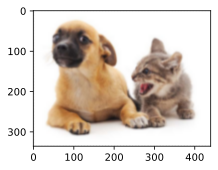

In [6]:
d2l.set_figsize()
img = d2l.plt.imread('/home/catdog.png')
d2l.plt.imshow(img)

##边界框
&emsp;&emsp;在⽬标检测中，通常使⽤边界框（bounding box）来描述对象的空间位置。边界框是矩形的，由矩形左⻆的 x 和 y 坐标以及右下⻆的坐标决定。另⼀种常⽤的边界框表⽰⽅法是边界框中⼼的 (x, y) 轴坐标以及框的宽度和⾼度。

In [29]:
def box_corner_to_center(boxes):
  """从（左上，右下）转换到（中间，宽度，高度）"""
  x1,y1,x2,y2 = boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
  cx = (x1+x2) / 2
  cy = (y1+y2) / 2
  w = x2-x1
  h = y2-y1
  boxes = torch.stack((cx,cy,w,h),axis=-1)
  return boxes

def box_center_to_corner(boxes):
  """从（中间，宽度，高度）转换到（左上，右下）"""
  cx,cy,w,h = boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1,y1,x2,y2),axis=-1)
  return boxes

In [30]:
dog_bbox, cat_bbox = [30.0, 22.5, 235.0, 305.0], [245.0, 56.0, 400.0, 295.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [31]:
def bbox_to_rect(bbox, color):
# 将边界框 (左上x, 左上y, 右下x, 右下y) 格式转换成 matplotlib 格式：
# ((左上x, 左上y), 宽, ⾼)
  return d2l.plt.Rectangle(
    xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
    fill=False, edgecolor=color, linewidth=2)

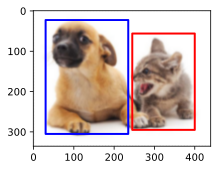

In [32]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

##小结
* ⽬标检测不仅可以识别图像中所有感兴趣的物体，还能识别它们的位置，该位置通常由矩形边界框表
⽰。
* 我们可以在两种常⽤的边界框表⽰（中间，宽度，⾼度）和（左上，右下）坐标之间进⾏转换。

##目标检测数据集

In [35]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
#下载数据集
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL+'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [52]:
#读取数据集
def read_data_bananas(is_train=True):
  """读取香蕉检测数据集中的图像和标签"""
  data_dir = d2l.download_extract('banana-detection')
  csv_fname = os.path.join(data_dir,'bananas_train'if is_train else 'bananas_val','label.csv')
  csv_data = pd.read_csv(csv_fname)
  csv_data = csv_data.set_index('img_name')
  images,targets = [],[]
  for img_name,target in csv_data.iterrows():
    images.append(torchvision.io.read_image(
        os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
    targets.append(list(target))
  return images,torch.tensor(targets).unsqueeze(1) / 256

In [53]:
class BananasDataset(torch.utils.data.Dataset):
  """⼀个⽤于加载⾹蕉检测数据集的⾃定义数据集。"""
  def __init__(self, is_train):
    self.features, self.labels = read_data_bananas(is_train)
    print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
  def __getitem__(self, idx):
    return (self.features[idx].float(), self.labels[idx])
  def __len__(self):
    return len(self.features)

In [54]:
def load_data_bananas(batch_size):
  """加载⾹蕉检测数据集。"""
  train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),batch_size, shuffle=True)
  val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),batch_size)
  return train_iter, val_iter

In [55]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

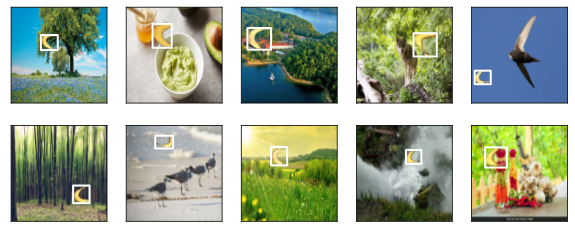

In [56]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
  d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

##小结
* 我们收集的⾹蕉检测数据集可⽤于演⽰⽬标检测模型。
* ⽤于⽬标检测的数据加载与图像分类的数据加载类似。但是，在⽬标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。